In [1]:
import pandas as pd
import numpy as np

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [3]:
import tensorflow as tf

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import matplotlib.pyplot as plt

# Data location

In [6]:
data_path = "data/clean_data.csv"

# Set seed

In [7]:
SEED = 42

# Load data

In [8]:
df = pd.read_csv(data_path)

In [9]:
df.shape

(11627, 40)

In [10]:
df.columns

Index(['Unnamed: 0', 'RANDID', 'SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP',
       'CURSMOKE', 'CIGPDAY', 'BMI', 'DIABETES', 'BPMEDS', 'HEARTRTE',
       'GLUCOSE', 'educ', 'PREVCHD', 'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP',
       'TIME', 'PERIOD', 'HDLC', 'LDLC', 'DEATH', 'ANGINA', 'HOSPMI',
       'MI_FCHD', 'ANYCHD', 'STROKE', 'CVD', 'HYPERTEN', 'TIMEAP', 'TIMEMI',
       'TIMEMIFC', 'TIMECHD', 'TIMESTRK', 'TIMECVD', 'TIMEDTH', 'TIMEHYP'],
      dtype='object')

In [11]:
df.iloc[:, 2: 24].columns

Index(['SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CURSMOKE', 'CIGPDAY', 'BMI',
       'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'educ', 'PREVCHD',
       'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'TIME', 'PERIOD', 'HDLC',
       'LDLC'],
      dtype='object')

In [12]:
df.iloc[:, 24: 32].columns

Index(['DEATH', 'ANGINA', 'HOSPMI', 'MI_FCHD', 'ANYCHD', 'STROKE', 'CVD',
       'HYPERTEN'],
      dtype='object')

In [13]:
print(df.iloc[:, 2: 24].shape[1], df.iloc[:, 24: 32].shape[1])

22 8


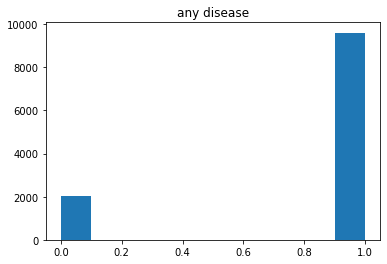

In [14]:
data = np.loadtxt(data_path, delimiter=",", dtype=np.float32, skiprows=1)
amax_label = np.amax(data[:, 24:32], axis=1)
hist,bins = np.histogram(amax_label) 

plt.hist(amax_label, bins = bins) 
plt.title("any disease") 
plt.show()

# DataSet

In [15]:
class HeatDeseaseDataset(Dataset): 
    
    def __init__(self, path, any_disease=False):
        
        self.data = np.loadtxt(path, delimiter=",", dtype=np.float32, skiprows=1)
        self.x = torch.from_numpy(self.data[:, 2:24])
        if any_disease:
            self.y = torch.from_numpy(np.amax(self.data[:, 24:32], axis=1))
        else:
            self.y = torch.from_numpy(self.data[:, 24:32])
        
        self.len = len(self.data)

    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]#, self.original[idx]

# DataLoader

In [16]:
def create_dataloaders(dataset, batch_size):
    lengths = [round(len(dataset) * split) for split in [TRAIN_SPLIT, VALIDATION_SPLIT, TEST_SPLIT]]
    
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths=lengths, generator=torch.Generator().manual_seed(SEED))
    
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        prefetch_factor=2,
        persistent_workers=False,
        pin_memory=True
    )

    val_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        prefetch_factor=2,
        persistent_workers=False,
        pin_memory=True
    )

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=True,
        num_workers=4,
        prefetch_factor=2,
        persistent_workers=False,
        pin_memory=True
    )
    
    print(f'Total dataset: {len(train_dataloader) + len(val_dataloader) + len(test_dataloader)}, '
            f'train dataset: {len(train_dataloader)}, val dataset: {len(val_dataloader)}, test_dataset: {len(test_dataloader)}')
    return train_dataloader, val_dataloader, test_dataloader

# Accuracy

In [17]:
def accuracy_multi_prediction(pred, label):
    res = 0
    nb_prediction = pred.shape[1]

    for i in range(nb_prediction):
        if pred[0][i].item() == label[0][i].item():
            res += 1
    return res / nb_prediction

In [18]:
def accuracy(pred, label):
    if pred[0].item() == label[0].item():
            return 1
    return 0

# Trainer

In [19]:
class Trainer:
    def __init__(self, model, loss='dl', lr=0.1):
        possible_loss = {'dl': DiceLoss(), 'nllloss': nn.NLLLoss(), 'cross':nn.CrossEntropyLoss()}
        
        self.model = model
        
        self.criterion = possible_loss[loss]
        self.optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', factor=0.4, patience=2, cooldown=2)
        
        self.history = {'lr': [], 'loss': [], 'val_loss': []}
        self.max_val_loss = float('-inf')
        
    def fit(self, train_dataloader, val_dataloader, nb_epochs):
        for epoch in range(nb_epochs):
            print(f'Epoch {epoch} / {nb_epochs}')
            train_loss = val_loss = 0.0
            
            self.model.train()
            pbar = tf.keras.utils.Progbar(target=len(train_dataloader))
            
            for i, batch in enumerate(train_dataloader):
                inputs, labels = batch

                # Clear gradients w.r.t. parameters
                self.optimizer.zero_grad()
                
                # Forward pass to get output/logits
                outputs = self.model(inputs)

                # Calculate Loss: softmax --> cross entropy loss
                loss = self.criterion(outputs, labels)
                train_loss += loss

                # Getting gradients w.r.t. parameters
                loss.backward()

                pbar.update(i + 1, values=
                            [
                                ("loss", train_loss.item()/(i + 1)),
                                ("lr", self.scheduler.optimizer.param_groups[0]['lr'])
                            ])
                
                # Updating parameters
                self.optimizer.step()
                
            
            print('Validation')
            
            self.model.eval()
            pbar = tf.keras.utils.Progbar(target=len(val_dataloader))
            
            with torch.no_grad():
                for i, batch in enumerate(val_dataloader):
                    inputs, labels = batch
                    outputs = self.model(inputs)
                    val_loss += loss
                    pbar.update(i + 1, values=
                            [
                                ("loss", val_loss.item()/(i + 1)),
                                ("lr", self.scheduler.optimizer.param_groups[0]['lr'])
                            ])

            train_loss = train_loss / len(train_dataloader)
            val_loss = val_loss / len(val_dataloader)
            lr = self.scheduler.optimizer.param_groups[0]['lr']
            self.scheduler.step(val_loss)
            
            if val_loss > self.max_val_loss:
                print(f'Model saved. Loss updated: {self.max_val_loss:.3f} -> {val_loss:.3f}')
                self.max_val_loss = val_loss
                torch.save(self.model.state_dict(), f'regression_logistice_{val_loss.item()}.pt')
            
    def evaluate(self, test_dataloader, accuracy_function):
        correct = total_loss = total = 0.0
        #iterator = 0
        
        with torch.no_grad():       
            # Iterate through test dataset
            for i, (inputs, labels) in enumerate(test_dataloader):

                pred = self.model(inputs)

                loss = self.criterion(pred, labels)
                total_loss += loss
                    
                # Total correct predictions
                correct += accuracy_function(pred, labels)
                #iterator += 1

            total_accuracy = 100 * correct / len(test_dataloader)

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}. total loss: {}.'.format(len(test_dataloader), loss.item(), total_accuracy, total_loss))
     

# Loss

In [20]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

# The logistic regession function

In [21]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.final_activation(out)
        return out

# Prepare the data

In [22]:
TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.21
TRAIN_SPLIT = 1 - TEST_SPLIT - VALIDATION_SPLIT

In [23]:
batch_size = 1

dataset = HeatDeseaseDataset(data_path, any_disease=False)
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(dataset, batch_size)

Total dataset: 11627, train dataset: 6860, val dataset: 2442, test_dataset: 2325


# Data verification

In [24]:
participant = next(iter(train_dataloader))
print('input ==>\n', participant[0])
print('label ==>\n', participant[1])

input ==>
 tensor([[0.0000e+00, 2.2800e+02, 5.1000e+01, 1.3100e+02, 8.0000e+01, 0.0000e+00,
         0.0000e+00, 2.7940e+01, 0.0000e+00, 0.0000e+00, 6.5000e+01, 7.5000e+01,
         3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.2800e+03, 2.0000e+00, 4.4000e+01, 1.8700e+02]])
label ==>
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]])


# Train

In [25]:
model = LogisticRegression(22,8)

In [26]:
trainer = Trainer(model, loss='dl', lr=0.1)

In [27]:
trainer.fit(
    train_dataloader,
    val_dataloader,
    nb_epochs=10
) 

Epoch 0 / 10
6860/6860 [==============================] - 10s 1ms/step - loss: 0.6116 - lr: 0.1000
Validation
2442/2442 [==============================] - 2s 882us/step - loss: 0.7205 - lr: 0.1000
Model saved. Loss updated: -inf -> 0.720
Epoch 1 / 10
6860/6860 [==============================] - 9s 1ms/step - loss: 0.6099 - lr: 0.1000
Validation
2442/2442 [==============================] - 2s 953us/step - loss: 0.7205 - lr: 0.1000
Epoch 2 / 10
6860/6860 [==============================] - 9s 1ms/step - loss: 0.6103 - lr: 0.1000
Validation
2442/2442 [==============================] - 2s 917us/step - loss: 0.3101 - lr: 0.1000
Epoch 3 / 10
6860/6860 [==============================] - 9s 1ms/step - loss: 0.6054 - lr: 0.1000
Validation
2442/2442 [==============================] - 2s 921us/step - loss: 0.7205 - lr: 0.1000
Epoch 4 / 10
6860/6860 [==============================] - 9s 1ms/step - loss: 0.6093 - lr: 0.0400
Validation
2442/2442 [==============================] - 2s 942us/step - loss

# Test

In [43]:
torch.load(f'regression_logistice_0.720467746257782.pt')

OrderedDict([('linear.weight',
              tensor([[ 0.1831,  0.1496, -0.1546, -0.1647,  0.0406, -0.1001,  0.1980, -0.0625,
                        0.0810,  0.0430,  0.1321,  0.1623, -0.1760, -0.1212,  0.0022,  0.0566,
                       -0.1007,  0.1496, -0.1830, -0.2013, -0.2109,  0.1417],
                      [ 0.0648, -0.0225,  0.1108, -0.0578, -0.1714,  0.1243, -0.0385,  0.1886,
                       -0.0513, -0.0153,  0.1407,  0.1122,  0.0259,  0.1070, -0.0678,  0.0040,
                       -0.1454,  0.2005,  0.1366,  0.1368,  0.1434,  0.1434],
                      [-0.0456,  0.2558,  0.1183,  0.2165, -0.0627, -0.1332, -0.2061, -0.0949,
                       -0.0073,  0.1266,  0.1023, -0.2082,  0.1126, -0.1570,  0.0218,  0.0033,
                       -0.1741,  0.0187,  0.0086,  0.1961,  0.0420, -0.0767],
                      [ 0.0500,  0.3488,  0.0951, -0.0525, -0.1215,  0.1400, -0.1748, -0.0468,
                        0.1045, -0.1133,  0.1354,  0.0501,  0.0005,  0

In [44]:
trainer.evaluate(test_dataloader, accuracy_multi_prediction)

Iteration: 2325. Loss: 0.544615626335144. Accuracy: 28.059139784946236. total loss: 1429.2471923828125.


**Test on one participant**

In [47]:
    for i, (inputs, labels) in enumerate(test_dataloader):
        pred = model(inputs)
        
        if i ==1:
            break
    pred, labels

(tensor([[1.0000e+00, 1.0000e+00, 8.4246e-16, 1.0000e+00, 1.0000e+00, 1.0000e+00,
          1.0000e+00, 1.0000e+00]], grad_fn=<SigmoidBackward0>),
 tensor([[1., 0., 0., 1., 1., 1., 1., 1.]]))

In [48]:
print(len(test_dataloader))

2325


In [36]:
# Confusion matrix 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def prediction_analyse(dataloader):
    all_predictions = np.array([])
    all_labels = np.array([])
    for i, (inputs, labels) in enumerate(dataloader):
        pred = model(inputs)
       # print(pred[0].detach().numpy(), "label", labels)
        pred = np.where( pred[0].detach().numpy() < 0.5, 0, 1)
        #print(pred)
        all_predictions = np.append(all_predictions, pred)
        all_labels = np.append(all_labels, labels[0].detach().numpy())

    #
    #print(all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)
    #
    #print(cm)

    display = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=clf.classes_)
    display.plot()
    plt.show()

    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatif

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    #positive predictive value
    PPV = TP / (TP + FP)
    #negative predictive value
    NPV = TN / (TN + FN)


    print(f'sensitivity : {sensitivity}, specificity : {specificity}, PPV : {PPV}, NPV : {NPV}')

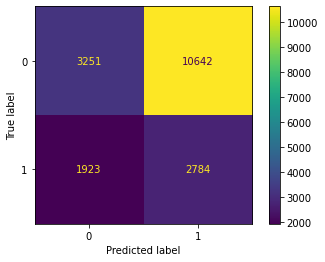

sensitivity : 0.591459528362014, specificity : 0.23400273519038364, PPV : 0.2073588559511396, NPV : 0.6283339775802087


In [49]:
prediction_analyse(test_dataloader)